_I wrote this originally as a set of notes to a student, so it is a bit informal and conversational. I hope it is still useful!_

The Fisher information matrix is the expectation value of the variance of the log-likelihood function, which is often just the expectation of the Hessian of the log-likelihood function (i.e. the second derivatives with respect to the model parameters). That's just a boring definition! For a data set $D$ and model parameters $\theta$, 
$$
\mathcal{F}_{jk} = -\mathbb{E}\left[\frac{\partial^2}{\partial\theta_j \, \partial\theta_k}\ln\mathcal{L}(D \,|\, \theta)\right]
$$
where $\mathbb{E}\left[x\right]$ is the expectation value of $x$ evaluated at the true parameter values.
Conceptually, it is a matrix that tells us how much information the data $D$ contain about a given parameter, or how much covariance there is in our knowledge of a combination of parameters. 

I think of it as a result of a Taylor expansion of the likelihood function around the maximum likelihood parameter values. It is related to the curvature of the likelihood function around its maximum (because second derivatives are involves). It is not a fundamental object that is universally interpretable or meaningful. For example, if a model is a bad representation of data, or if the likelihood surface is extremely structured or multi-modal (i.e. cases where a Taylor expansion to low order is a bad representation of a function), then the Fisher information does not really summarize any useful properties of the data or model. 

Examples:
1. [Fitting a line to data](#example-fitting-a-line-to-data)
2. [Multi-dimensional and nonlinear (but still Gaussian) models](#example-multi-dimensional-and-nonlinear-but-still-gaussian-models)
3. [What if the model has nuisance parameters?](#example-what-if-your-model-has-nuisance-parameters)
4. [What if the likelihood is very structured?](#example-what-if-the-likelihood-is-very-structured)

# Example: Fitting a line to data

As an example of how to compute this thing, let's use the ever-loved example of [fitting a straight line to data](https://adrian.pw/blog/fitting-a-line/) $y$ at positions $x$ with uncertainties $\sigma_y$ only on the data $y$. Let's generate some fake data to work with:

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
ndata = 8
rng = np.random.default_rng(42)
true_pars = rng.normal(0, 2.0, size=2)

x = np.sort(rng.uniform(0, 10, ndata))
yerr = 10 ** rng.uniform(-1, 0, ndata)
y = rng.normal(true_pars[0] * x + true_pars[1], yerr)

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

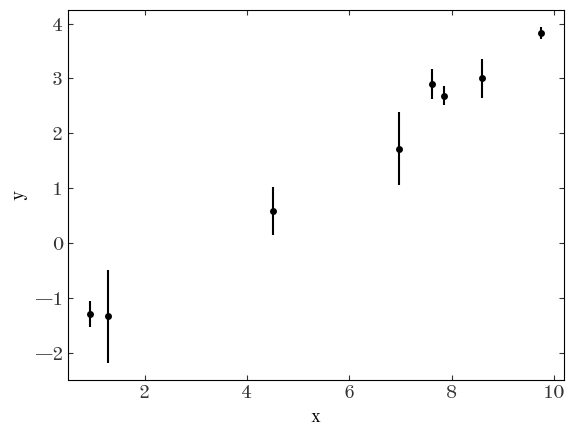

In [3]:
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, marker="o", ls="none")
ax.set(xlabel="x", ylabel="y")

In this case, our model for the data is one dimensional and linear:
$$
f(x \,;\, \theta) = a \, x + b \\
\theta = (a, b)
$$
and we will assume that the data are generated from some process such that the uncertainties $\sigma_y$ are Gaussian (and I'll drop the subscript $y$ because I'm lazy). Our likelihood function for a single data point $(x_i, y_i, \sigma_i)$ is then:
$$
L(y_i \,;\, \theta) = \mathcal{N}(y_i \,|\, f(x \,;\, \theta), \sigma_i)
$$
($x_i$ and $\sigma_i$ aren't really data because we assume we know them perfectly, but they are associated with a given data point $y$ as metadata). 
$\mathcal{N}(w \,|\, \mu, \sigma)$ is the Normal distribution over $w$ with mean $\mu$ and standard deviation $\sigma$.

In this model, the data points are independent, so the total likelihood $\mathcal{L}$ is just the product of the likelihoods for each individual data point:
$$
\begin{align}
\mathcal{L} &= \prod_i L(y_i \,;\, \theta)\\ 
&= \prod_i \mathcal{N}(y_i \,|\, f_i, \sigma_i)
\end{align}
$$
where, as a reminder, $f_i$ is the model predicted value of $y$ at a given location $x_i$ — you can think of it as the model's prediction for the true value of $y_i$.
In the log, this product is just a sum:
$$
\ln\mathcal{L} = \sum_i \ln\mathcal{N}(y_i \,|\, f_i, \sigma_i)
$$

So now we need to take second derivatives of this thing. The derivative here can be moved inside of the sum, so  
$$
\frac{\partial^2\ln\mathcal{L}}{\partial \theta_j \partial \theta_k} = \sum_i \frac{\partial^2}{\partial \theta_j \partial \theta_k}\ln\mathcal{N}(y_i \,|\, f_i, \sigma_i)
$$

To see how this works in this one-dimensional case, let's expand the expression for the log-Normal distribution:
$$
\ln\mathcal{N}(y_i \,|\, f_i, \sigma_i) = -\frac{1}{2} \left[ \frac{(y_i - f_i)^2}{\sigma_i^2} + \ln(2\pi\,\sigma_i^2) \right]
$$
(this may seem like a weird way to write it but trust me). Now, we need to take derivatives of this expression with respect to the model parameters $\theta$. One thing to note is that the second term $\ln(2\pi\,\sigma^2)$ does not depend on the parameters (it is only a function of the data, i.e. the uncertainties), so the derivatives of this term are zero. The first term is a quadratic function of $y_i$ and $f_i$, but $y_i$ is data and $f_i$ is a function of the model parameters, so the only terms that survive the derivative are those that depend on $f_i$ (i.e. the model predictions):
$$
\frac{\partial^2}{\partial \theta_j \partial \theta_k} 
    \ln\mathcal{N}(y_i \,|\, f_i, \sigma_i) = 
        \frac{1}{\sigma_i^2} \frac{\mathrm{d} f_i}{\mathrm{d}\theta_j} 
            \frac{\mathrm{d} f_i}{\mathrm{d}\theta_k}
$$

Our model $f$ only has two parameters, so we can write this matrix out explicitly, for one data point:
$$
\begin{align}
&= \frac{1}{\sigma_i^2} \, \begin{pmatrix}
\frac{\mathrm{d} f_i}{\mathrm{d}a} \frac{\mathrm{d} f_i}{\mathrm{d}a} & \frac{\mathrm{d} f_i}{\mathrm{d}a} \frac{\mathrm{d} f_i}{\mathrm{d}b} \\
\frac{\mathrm{d} f_i}{\mathrm{d}b} \frac{\mathrm{d} f_i}{\mathrm{d}a} & \frac{\mathrm{d} f_i}{\mathrm{d}b} \frac{\mathrm{d} f_i}{\mathrm{d}b}
\end{pmatrix} \\
&= \frac{1}{\sigma_i^2} \, \begin{pmatrix}
x_i^2 & x_i \\
x_i & 1 
\end{pmatrix}
\end{align}
$$

And so the Fisher information matrix is just the sum of these matrices over all data points:
$$
\mathcal{F} = \sum_i \frac{1}{\sigma_i^2} \, \begin{pmatrix}
x_i^2 & x_i \\
x_i & 1
\end{pmatrix}
$$

This is an interesting (but simple) result: the Fisher information here does not even contain the model parameter values! That is because our model $f$ is _linear_ in the model parameters and our likelihood is Gaussian, so the curvature is a constant. Let's look at how to compute this given our toy data above.

In [4]:
# This is the matrix component of the Fisher information from above
M = np.array([[x**2, x], [x, np.ones_like(x)]])
M.shape

(2, 2, 8)

In [5]:
F = np.sum(1 / yerr**2 * M, axis=-1)
F.shape

(2, 2)

In [6]:
F

array([[10822.60583843,  1226.64589812],
       [ 1226.64589812,   157.35632654]])

OK so we've computed the Fisher information! ...So what? It turns out that the inverse of the Fisher information matrix is a useful matrix itself: it is the covariance matrix of the maximum likelihood parameter estimates. This is also known as the "Cramér–Rao bound." This is a useful property because it tells us the expected precision of our parameter estimates given the data we have. If the Fisher information is large, then the parameter uncertainties (i.e. the inverses) are small, so the parameters are well-constrained by the data. Let's look at the inverse of the Fisher information matrix for our toy data above:

In [7]:
Finv = np.linalg.inv(F)
Finv

array([[ 0.00079335, -0.00618439],
       [-0.00618439,  0.05456446]])

If we ignore the covariances (i.e. the off-diagonal terms), this tells us the expected errors we would get on the parameter values if we fit the data with a straight line. The diagonal terms are the variances of the parameter estimates, and the square roots of these are the expected standard deviations of the parameter estimates:

In [8]:
np.sqrt(np.diag(Finv))

array([0.02816638, 0.23359036])

Let's now do a maximum likelihood fit using least-squares algebra and compare the results to the Fisher information matrix. With least-squares:

In [9]:
# Design matrix:
A = np.stack((x, np.ones_like(x)), axis=-1)

# Data covariance matrix:
Cinv = np.diag(1 / yerr**2)

Here is the standard matrix algebra for computing the maximum likelihood parameter estimates for a linear model (`mle_pars` below). In this case, the covariance matrix of the parameter estimates, $P$, is the inverse of the Fisher information matrix! (BTW, as an aside, it's generally bad to construct the data covariance matrix this way and to do the matrix inverse explicitly here — a better way is to use, e.g., `numpy.linalg.leastsq` or `numpy.linalg.solve`)

In [10]:
P = np.linalg.inv(A.T @ Cinv @ A)
mle_pars = P @ A.T @ Cinv @ y
mle_pars

array([ 0.58499692, -1.87999557])

In [11]:
# Note that these are the same values as sqrt(diag(Finv))!
np.sqrt(np.diag(P))

array([0.02816638, 0.23359036])

# Example: Multi-dimensional and nonlinear (but still Gaussian) models

The example above is a special case where we can solve for the Fisher information analytically and our model is linear. We are often in more complex situations in astronomy. One example is our project (where our likelihood function involves orbit integrations; here the model is nonlinear and the data are multi-dimensional). Another example is solving the Kepler problem by fitting a two-body orbit to, e.g., radial velocity data (model is nonlinear in the parameters but the data are still one dimensional). 

In general, our data may be a vector $\boldsymbol{y}$ and our model may be a multi-output or vector function $\boldsymbol{f}(\boldsymbol{x} \,;\, \boldsymbol{\theta})$ where $\boldsymbol{x}$ is a vector of independent variables and $\boldsymbol{\theta}$ is a vector of model parameters. If the likelihood is non-Gaussian, there's not much we can do analytically. But if the likelihood is Gaussian, even with a nonlinear model, we can simplify the Fisher information matrix calculation by using the chain rule for derivatives.

In this case, our likelihood for one data point $\boldsymbol{y}_i$ (note the vector $y$) is:
$$
L(\boldsymbol{y}_i \,;\, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{y}_i \,|\, \boldsymbol{f}_i, \boldsymbol{\Sigma}_i)
$$
where now $\boldsymbol{\Sigma}_i$ is the covariance matrix of the data point $\boldsymbol{y}_i$, and $\boldsymbol{f}_i$ is a vector of model-predicted "true" values for the data. We can expand the log-Normal expression in the same way as we did for the one-dimensional case above, but now it involves some matrix algebra:
$$
\ln L(\boldsymbol{y}_i \,;\, \boldsymbol{\theta}) = 
    -\frac{1}{2} \left[ (\boldsymbol{y}_i - \boldsymbol{f}_i)^{\mathrm{T}} \boldsymbol{\Sigma}_i^{-1} (\boldsymbol{y}_i - \boldsymbol{f}_i) + \ln\det\boldsymbol{\Sigma}_i + N \ln(2\pi) \right]
$$
where $\det$ is the determinant of a matrix and $N$ is the number of data points. We again want derivatives of this expression with respect to model parameters $\boldsymbol{\theta}$, so once again we can ignore the second and third terms because they are independent of the model parameters. The first term is a quadratic form in the data and model predictions, so the only terms that survive the derivative are those that depend on the model predictions:
$$
\frac{\partial^2}{\partial \theta_j \partial \theta_k} 
    \ln L(\boldsymbol{y}_i \,;\, \boldsymbol{\theta}) = 
        \frac{\partial \boldsymbol{f}^{\mathrm{T}}_i}{\partial \theta_j} \boldsymbol{\Sigma}_i^{-1} \frac{\partial \boldsymbol{f}_i}{\partial \theta_k} 
$$
This is the quantity you might see in, for example, [Bonaca & Hogg 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...867..101B/abstract) (or an upcoming paper by Sophia Lilleengen on information theory of stellar streams).

Let's now do an example of this for a two-dimensional model with some nonlinear model parameters. For example, a sinusoidal model of two variables with unknown amplitudes and frequency:
$$
\boldsymbol{f}(x \,;\, \boldsymbol{\theta}) = 
    \begin{pmatrix}
    a \, \sin(2\pi \, \nu \, x) \\
    b \, \cos(2\pi \, \nu \, x)
    \end{pmatrix}
$$

We again generate some toy data to play with (and yes I'm being naughty by using the same variable names as above):

In [12]:
ndata = 16
rng = np.random.default_rng(8675309)
true_pars = np.abs(rng.normal(0, 2.0, size=3))

x = np.sort(rng.uniform(0, 2 / true_pars[2], ndata))
yerr = 10 ** rng.uniform(-2, -0.5, (ndata, 2)) * true_pars[:2]
true_pars = {"a": true_pars[0], "b": true_pars[1], "freq": true_pars[2]}

y = np.stack(
    (
        rng.normal(
            true_pars["a"] * np.sin(2 * np.pi * true_pars["freq"] * x), yerr[:, 0]
        ),
        rng.normal(
            true_pars["b"] * np.cos(2 * np.pi * true_pars["freq"] * x), yerr[:, 1]
        ),
    ),
    axis=-1,
)

# The inverse covariance matrix of the data (which here is diagonal):
Cinv = np.stack([np.diag(1 / yerr[i] ** 2) for i in range(ndata)], axis=0)

# We'll work with the data in a dictionary for convenience:
data = {"x": x, "y": y, "Cinv": Cinv, "yerr": yerr}
data["Cinv"].shape, data["y"].shape

((16, 2, 2), (16, 2))

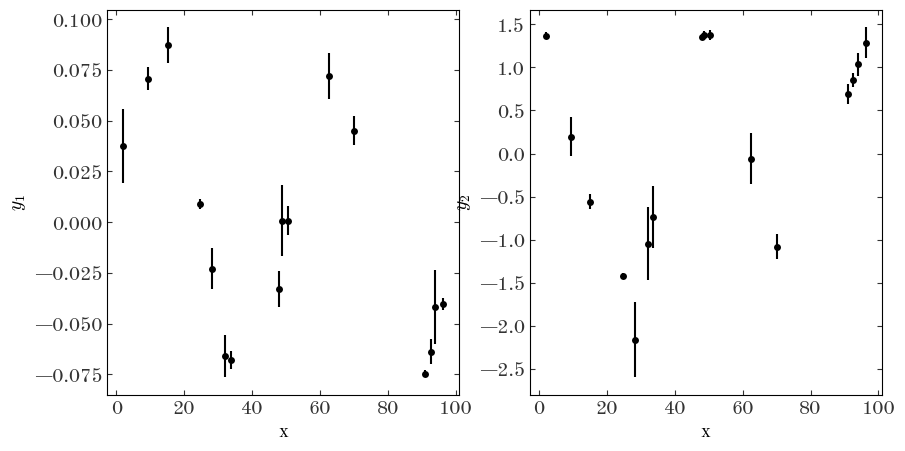

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axes[i].errorbar(
        data["x"], data["y"][..., i], data["yerr"][..., i], marker="o", ls="none"
    )
    axes[i].set(xlabel="x", ylabel=f"$y_{i+1}$")

Now let's implement this model in JAX so we can make use of the auto-differentiation capabilities. We'll again compute the Fisher information matrix and compare it to the maximum likelihood parameter estimates.

In [14]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [15]:
@jax.jit
def model_f(x, pars):
    return jnp.stack(
        (
            pars["a"] * jnp.sin(2 * jnp.pi * pars["freq"] * x),
            pars["b"] * jnp.cos(2 * jnp.pi * pars["freq"] * x),
        ),
        axis=-1,
    )


@jax.jit
def ln_likelihood_one_star(pars, x, y, Cinv):
    y_model = model_f(x, pars)
    dy = y - y_model
    return -0.5 * dy.T @ Cinv @ dy


ln_likelihood_helper = jax.vmap(ln_likelihood_one_star, in_axes=(None, 0, 0, 0))


@jax.jit
def ln_likelihood(pars, x, y, Cinv):
    return jnp.sum(ln_likelihood_helper(pars, x, y, Cinv))

Let's try evaluating our log-likelihood function at the true parameters:

In [16]:
ln_likelihood(true_pars, x, y, Cinv)

Array(-11.87854157, dtype=float64)

In [17]:
F = jax.hessian(ln_likelihood)(true_pars, x, y, Cinv)
F = -np.array([list(f.values()) for f in F.values()])

And once again, we can turn this into a prediction for the uncertainty on our model parameters:

In [18]:
Finv = np.linalg.inv(F)
Fisher_param_uncertainties = np.sqrt(np.diag(Finv))
Fisher_param_uncertainties

array([1.78625210e-03, 1.34166769e-02, 4.98967477e-05])

In this case, because our model is nonlinear, we can't use the least-squares expressions above to analytically compute the maximum likelihood parameter estimates and precisions. Instead, we will specify a prior and use MCMC to generate samples from the posterior distribution. We can then compare the covariance matrix of the samples to the inverse of the Fisher information matrix (or just the diagonal terms, the parameter uncertainties).

In [19]:
@jax.jit
def ln_prior(pars):
    lp = 0.0

    # Gaussian priors on the amplitudes with mean=0, stddev=10:
    lp += jax.scipy.stats.norm.logpdf(pars["a"], 0, 10)
    lp += jax.scipy.stats.norm.logpdf(pars["b"], 0, 10)

    # Uniform prior on the frequency:
    lp += jax.scipy.stats.uniform.logpdf(pars["freq"], 0, 1)
    lp = jnp.where((pars["freq"] > 0) & (pars["freq"] < 1), lp, -jnp.inf)

    return lp


@jax.jit
def ln_posterior(pars, x, y, Cinv):
    return ln_likelihood(pars, x, y, Cinv) + ln_prior(pars)

In [20]:
import blackjax

rng_key, warmup_key, sample_key = jax.random.split(jax.random.PRNGKey(42), 3)
init_pars = true_pars
func = lambda pars: ln_posterior(pars, x, y, Cinv)

warmup = blackjax.window_adaptation(blackjax.nuts, func)
(state, parameters), _ = warmup.run(warmup_key, init_pars, num_steps=1000)

In [21]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [22]:
kernel = blackjax.nuts(func, **parameters).step
states = inference_loop(sample_key, kernel, state, 10_000)

mcmc_samples = states.position

First, let's look at the parameter uncertainties as estimated by MCMC:

In [23]:
{k: np.std(samples, axis=0) for k, samples in mcmc_samples.items()}

{'a': Array(0.00182059, dtype=float64),
 'b': Array(0.01345026, dtype=float64),
 'freq': Array(5.03068845e-05, dtype=float64)}

Let's compare that to our Fisher approach above:

In [24]:
Fisher_param_uncertainties

array([1.78625210e-03, 1.34166769e-02, 4.98967477e-05])

These are very similar, as we expect!

We can also look at the full covariance matrix:

In [25]:
np.cov(np.stack(list(mcmc_samples.values())))

array([[ 3.31488757e-06, -4.44198391e-06,  4.81551850e-08],
       [-4.44198391e-06,  1.80927702e-04, -2.51937535e-07],
       [ 4.81551850e-08, -2.51937535e-07,  2.53103573e-09]])

In [26]:
Finv

array([[ 3.19069658e-06, -4.78172971e-06,  4.57876380e-08],
       [-4.78172971e-06,  1.80007218e-04, -2.60004737e-07],
       [ 4.57876380e-08, -2.60004737e-07,  2.48968543e-09]])

# Example: What if the model has nuisance parameters?

A common situation in forecasting (i.e. working with these information theoretic predictions) is that you would like to compute the Cramér–Rao bound (CRB) for one parameter, but your model has a number of other "nuisance" parameters that you don't care as much about. In these cases, you must still compute the full Fisher information (for all parameters and nuisances) and invert the whole matrix to get the CRB for the parameter of interest. As an example, we'll return to the case of fitting a line to data, but now with outlier data points (i.e. foreground or background data).

As always, we start by generating some toy data.

In [27]:
ndata = 32
rng = np.random.default_rng(123)
true_pars = rng.normal(0, 2.0, size=2)
true_pars = {
    "a": true_pars[0],
    "b": true_pars[1],
    "prob_outlier": 0.3,
    "outlier_scale": 2.5,
}

x = np.sort(rng.uniform(0, 10, ndata))
yerr = 10 ** rng.uniform(-1, 0, ndata)
y = rng.normal(true_pars["a"] * x + true_pars["b"], yerr)

outlier_idx = np.sort(
    rng.choice(ndata, int(ndata * true_pars["prob_outlier"]), replace=False)
)
y[outlier_idx] = rng.normal(
    true_pars["a"] * 5.0, true_pars["outlier_scale"], len(outlier_idx)
)
data = {"x": x, "y": y, "yerr": yerr}

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

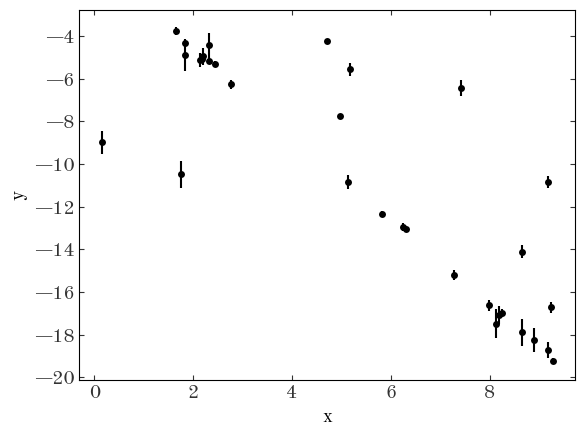

In [28]:
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, marker="o", ls="none")
ax.set(xlabel="x", ylabel="y")

Now we can see that this data set has some outliers away from the clear linear over-density. We will handle this by writing the likelihood as a [mixture model](https://adrian.pw/blog/hierarchical-models-2/). Note that we will just use the likelihood below to compute the Fisher information matrix evaluated at the true parameters, but in practice you would want to do something better with the mixture weight (`prob_outlier`) parameter.

In [29]:
@jax.jit
def ln_likelihood_one_star(pars, data):
    return jnp.logaddexp(
        jnp.log(pars["prob_outlier"])
        + jax.scipy.stats.norm.logpdf(
            data["y"], 0.0, jnp.sqrt(pars["outlier_scale"] ** 2 + data["yerr"] ** 2)
        ),
        jnp.log(1 - pars["prob_outlier"])
        + jax.scipy.stats.norm.logpdf(
            data["y"], pars["a"] * data["x"] + pars["b"], data["yerr"]
        ),
    )


ln_likelihood_helper = jax.vmap(
    ln_likelihood_one_star, in_axes=(None, {"x": 0, "y": 0, "yerr": 0})
)


@jax.jit
def ln_likelihood(pars, data):
    return jnp.sum(ln_likelihood_helper(pars, data))

In [30]:
ln_likelihood(true_pars, data)

Array(-107.319453, dtype=float64)

As we did above, we will use JAX to compute the Fisher information matrix and invert it:

In [31]:
F = jax.hessian(ln_likelihood)(true_pars, data)
F = -np.array([list(f.values()) for f in F.values()])
Finv = np.linalg.inv(F)

So what do we do if we only care about the CRB for the slope $a$ and intercept $b$ and not the outlier fraction or scale? We can just look at the sub-matrix corresponding to the parameters we care about! For example, for $a$ and $b$, this is the upper-left 2x2 sub-matrix of the full Fisher information matrix:

In [32]:
Finv[:2, :2]

array([[ 0.00021924, -0.00116053],
       [-0.00116053,  0.0077872 ]])

This example was more complex but still tractable relative to many real-world problems. In general, if you have many nonlinear parameters and your model either has significant structure in some dimensions or some implicit degeneracies between parameters, it might be hard or impossible to invert the Fisher information matrix stably. Or, you may have to reparameterize your model to make the Fisher information matrix more well-conditioned. 

# Example: What if the likelihood is very structured?

In the previous examples, the Fisher information matrix was a useful summary of the data and model. But what if the likelihood is very structured or multi-modal? As mentioned above, in these cases, the Fisher information matrix does not give us much useful information. For example, let's consider a one-dimensional case where the data are generated from a sinusoidal model where the only unknown parameter is the frequency of the sinusoid, but we have very few observations. We'll generate some toy data and compute the Fisher information matrix as usual (yes I'm using the same variable names again! Fire me...)

In [33]:
ndata = 3
rng = np.random.default_rng(101)
true_pars = jnp.array([0.19234])  # a random value, single parameter

x = np.sort(rng.uniform(0, 2 / true_pars[0], ndata))
yerr = 10 ** rng.uniform(-2, 0, ndata)
y = rng.normal(np.sin(2 * np.pi * true_pars[0] * x), yerr)

# The inverse covariance matrix of the data (which here is diagonal):
Cinv = (1 / yerr**2).reshape(ndata, 1, 1)

# We'll work with the data in a dictionary for convenience:
data = {"x": x, "y": y, "Cinv": Cinv, "yerr": yerr}
data["Cinv"].shape, data["y"].shape

((3, 1, 1), (3,))

[Text(0.5, 0, 'x'), Text(0, 0.5, '$y$')]

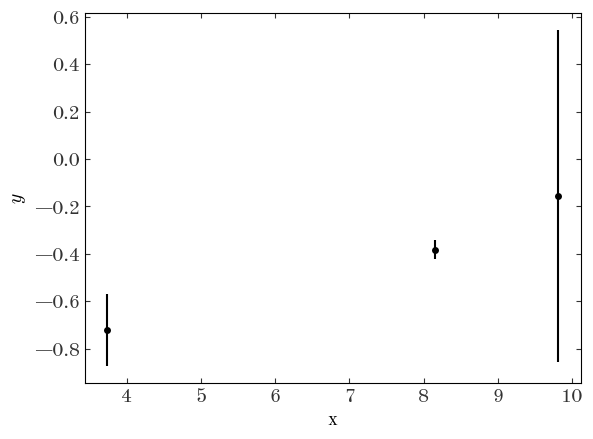

In [34]:
fig, ax = plt.subplots()
ax.errorbar(
    data["x"],
    data["y"],
    data["yerr"],
    marker="o",
    ls="none",
)
ax.set(xlabel="x", ylabel=f"$y$")

These data are clearly not very constraining for our model parameters! In other words, these data are consistent with many different distinct values of the frequency — we therefore expect the likelihood function to be very multi-modal: 

In [35]:
@jax.jit
def model_f(x, pars):
    return jnp.sin(2 * jnp.pi * pars[0] * x).reshape(-1, 1)


@jax.jit
def ln_likelihood_one_star(pars, x, y, Cinv):
    y_model = model_f(x, pars)
    dy = y - y_model
    return -0.5 * dy.T @ Cinv @ dy


ln_likelihood_helper = jax.vmap(ln_likelihood_one_star, in_axes=(None, 0, 0, 0))


@jax.jit
def ln_likelihood(pars, x, y, Cinv):
    return jnp.sum(ln_likelihood_helper(pars, x, y, Cinv))


ln_likelihood_over_samples = jax.vmap(ln_likelihood, in_axes=(0, None, None, None))

We can evaluate the likelihood over a grid of (logarithmically spaced) frequencies to see this:

[None, Text(0.5, 0, 'frequency'), Text(0, 0.5, 'normalized likelihood')]

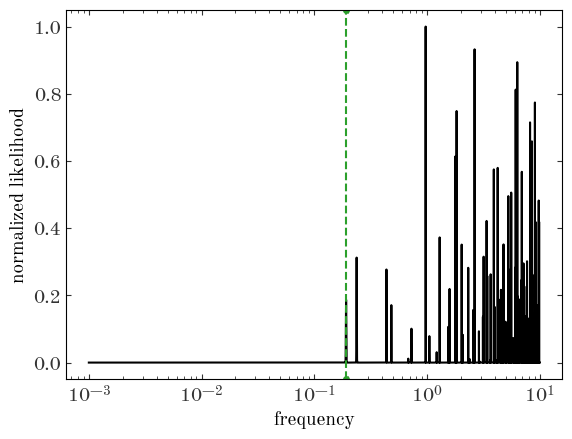

In [36]:
par_grid = 10 ** jnp.linspace(-3, 1, 65536).reshape(-1, 1)
ll_grid = ln_likelihood_over_samples(par_grid, x, y, Cinv)

fig, ax = plt.subplots()
ax.plot(par_grid, np.exp(ll_grid - ll_grid.max()), marker="")
ax.axvline(true_pars[0], color="tab:green", ls="--")
ax.set(xscale="log", xlabel="frequency", ylabel="normalized likelihood")

The Fisher information matrix and expected parameter variances is not going to be very informative in this case, but let's compute it at the true parameter values anyways:

In [37]:
F = -jax.hessian(ln_likelihood)(true_pars, x, y, Cinv)
Finv = np.linalg.inv(F)
fisher_freq_err = np.squeeze(np.sqrt(Finv))
fisher_freq_err

array(0.00084499)

At face value, Fisher analysis here tells us that we expect to be able to constrain our model parameter (the frequency) to a very high precision. But this is clearly not the case (based on the structure in the likelihood function)! This is because the Fisher information matrix gives us a _local_ measurement: it is related to the curvature of the one mode of the likelihood function near the true parameter values.

For this toy problem, optimization or even MCMC will not work well because the likelihood function is very structured. In this case, we would need to use a more sophisticated sampling method like nested sampling or just brute force rejection sampling to explore the corresponding posterior probability distribution containing this likelihood function. An example of this is below, just for fun! (and note this is basically the same problem as is solved by [thejoker](http://thejoker.readthedocs.io) and in [this paper](https://ui.adsabs.harvard.edu/abs/2017ApJ...837...20P/abstract)).

The procedure below generates samples from a prior distribution, and rejection samples using the likelihood function, which then represent samples from the posterior distribution. We can then look at the "true" uncertainty of the model parameter and compare to what our Fisher analysis told us above.

In [38]:
nsamples = 10_000_000
keys = jax.random.split(jax.random.PRNGKey(12345), 2)

prior_samples = 10 ** jax.random.uniform(
    keys[0], shape=(nsamples,), minval=-5, maxval=1
).reshape(-1, 1)

uu = jax.random.uniform(keys[1], shape=(nsamples,))

In [39]:
ln_likelihood_values = ln_likelihood_over_samples(
    prior_samples, data["x"], data["y"], data["Cinv"]
)

accepted_samples_mask = uu < np.exp(ln_likelihood_values - ln_likelihood_values.max())
print(accepted_samples_mask.sum())

posterior_samples = prior_samples[accepted_samples_mask]

13417


Let's visualize some of the posterior samples:

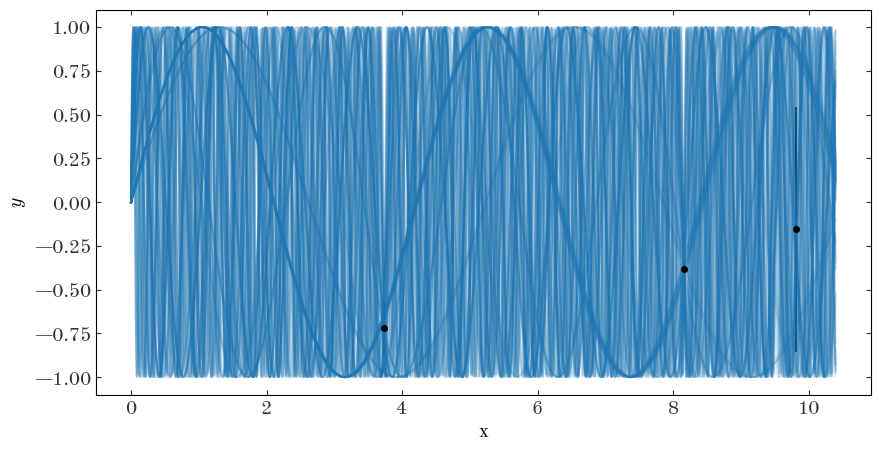

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(
    data["x"],
    data["y"],
    data["yerr"],
    marker="o",
    ls="none",
)
ax.set(xlabel="x", ylabel="$y$")

xgrid = np.linspace(0, 2 / true_pars[0], 1024)
for i in range(128):
    ax.plot(
        xgrid,
        model_f(xgrid, posterior_samples[i])[:, 0],
        marker="",
        ls="-",
        color="tab:blue",
        alpha=0.1,
    )

We can plot the Fisher-predicted uncertainty on the frequency parameter over a zoom-in of the posterior samples in frequency to see that it really only captures the curvature of the likelihood function in the mode near the true parameter value:

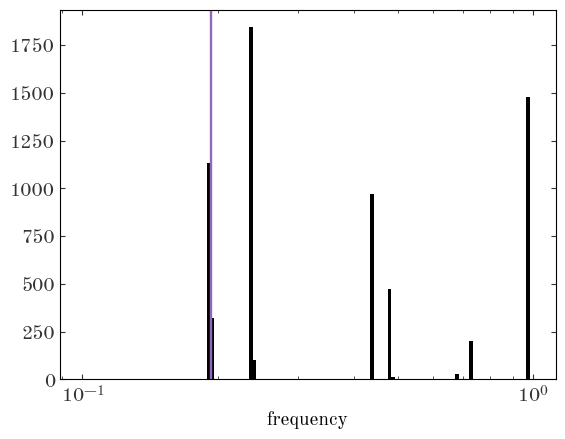

In [41]:
plt.hist(posterior_samples[:, 0], bins=np.logspace(-1, 0, 128))
plt.xscale("log")
plt.xlabel("frequency")

plt.axvspan(
    true_pars[0] - fisher_freq_err, true_pars[0] + fisher_freq_err, color="tab:purple"
)